# Data Challenge JDS 2018

## Introduction

Short-term forecasting is a major issue for the main french electricity utility "Electricité de France" (EDF). The purpose of forecasting is to predict future scenario and to adapt supply to demand. A major factor which impacts the demand are the weather conditions. Taking into account all parameters given by the weather forecast is a huge challenge, mainly for two reasons. The first one is that the number of parameters are too wide so that not all of them can be simultaneously considered, all the more when some parameters are not relevant for the desired forecast. The second reason is that the information on the weather is only a forecast, and the difference between the weather forecast and the actual situation can be different, especially if the weather forecast is given several days before.

This study falls within a forecasting challenge proposed by the "Young Statisticians and Probabilists" group during the "Journées de statistique" in May 2018. The data correspond to the electric consumption and the weather conditions in Ushant (France). The electric consumption consist of hourly data from 9.13.2015 to 9.12.2016. During the same period the weather data gather some tri-hourly climatic conditions as temperature, pression, wind speed.
This consists of the training data set. The forecasting data set corresponds to the weather forecast during the following week from 9.13.2016 to 9.20.2016. The aim of the challenge is then to predict the electric demand during this week based on the weather data.

Before dealing with the forecasting data, we use the training data to attempt two classic methods. The first one is the autoregressive moving average (ARMA) which leads us to a first exploratory data analysis. The second method is based on gradient boosting method (lightgbm). This second method allow us to optimize the parameters and use additional features. 
We use approximately a whole year as a training set, apply these methods on the next week for which the real electric consumption are available. The score is then computed to see if these methods give some good results on these data. As usual, the ARMA method is a good start without  requiring  any  additional  inputs  such
as  istorical  weather  data and give some good results on these types of data: the score with this method is about $6\%$.

Our method is a compromise between both forecasting algorithm. The first step is to use an ARMA model as before. Then the purpose is to build a hybrid forecast by a convex linear combination of the two methods, which improve the MAPE score. This method gathers thus a time series analysis with a machine learning method. 
As before, we first apply our method on the training set in order to compute the score. This allows us to do some calibrations according to the specificities of the data. We finally give the algorithm used on the forecasting data set.

Our study is organized as follows. Section 2 deals with a pre-processing of data and a set up of new features. In section 3, ARMA method is fit is used in part of our data set to have a first idea of which methods are the most interesting for our type of data. Section 4, shows a hyperparameter tuning and prediction with a GBM model. The main part of this paper is gathered in section 5: an ARMA method is combined with a Gradient Boosting method. The last Section predicts on the test data.

This combined method is first tested on a part of the data and gives some good score results. Then it is applied to forecast the unknown week's consumption, for which the result can not be computed yet. The paper ends with a discussion.

Note that the results of our method on the forecasting data are not known yet. We could only check our method on the training data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
sys.path.append('../script/')

# If you want to save the figures
savefigs = True
if savefigs:
    if not os.path.exists('./figures'):
        os.mkdir('./figures')

%matplotlib inline

## Data Processing

### Loading

A function `load_data` has been created to load the complete dataset. The power consumption and the weather data have been merged into one dataset. Some column names have also been changed for clarity reason.

In [2]:
from loading import load_data
data = load_data()
data.head()

,date,y,heure_ete,type,temperature,pression,HR,rosee,visibilite,v_moy,v_raf,v_dir,RR3h,neige,nebul
0,2015-09-13 00:00:00,NaN,True,train,12.5,1008.7,81.0,9.3,40.0,9.260,18.520,140.0,0.0,NaN,8.0
1,2015-09-13 01:00:00,526.166667,True,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-09-13 02:00:00,495.000000,True,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-09-13 03:00:00,446.166667,True,train,12.3,1006.4,83.0,9.5,40.0,11.112,16.668,120.0,0.0,NaN,8.0
4,2015-09-13 04:00:00,365.833333,True,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see above, the weather samples are filled with missing values, because only one measure is established every three hours. On the other hand, the consumption data is sampled every hour. We will explain in the next sections how we dealt with these missing values.

### On the consumption data

Now lets create more features from the dates such as the week, the day of the year, the hour, etc... Using the French calendar, we also consider the holiday dates for each part of the country. In French school holidays are divided in zones and the periods can of holidays can be different for each zone. The island we consider is in the Zone B. So we decide to only extract the holidays of this zone. However, holidays from other zones could be slightly influencial due to tourism from other zones. The data about school holidays have been obtained from [here](http://telechargement.index-education.com/vacances.xml).

The function `create_date_features` helps the extractions of these information.

In [3]:
from feature_functions import create_date_features
time_features = ['dayofweek', 'hour', 'dayofyear', 'hourofweek', 'week_type']
school_holiday_zones = ['B']

data = create_date_features(data, time_features, school_holiday_zones=school_holiday_zones)
data.head()

,date,y,heure_ete,type,temperature,pression,HR,rosee,visibilite,v_moy,...,RR3h,neige,nebul,national_holiday,dayofweek,hour,dayofyear,hourofweek,week_type,holiday_zone_B
0,2015-09-13 00:00:00,NaN,True,train,12.5,1008.7,81.0,9.3,40.0,9.260,...,0.0,NaN,8.0,False,6,0,256,144,sunday,False
1,2015-09-13 01:00:00,526.166667,True,train,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,6,1,256,145,sunday,False
2,2015-09-13 02:00:00,495.000000,True,train,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,6,2,256,146,sunday,False
3,2015-09-13 03:00:00,446.166667,True,train,12.3,1006.4,83.0,9.5,40.0,11.112,...,0.0,NaN,8.0,False,6,3,256,147,sunday,False
4,2015-09-13 04:00:00,365.833333,True,train,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,6,4,256,148,sunday,False


#### Yearly evolution of electricity consumption

We now want to visualize how the consumption evolves on the whole dataset. We also highlights some information on the plot such as the school holidays, the national holidays and day of hour changing in France.

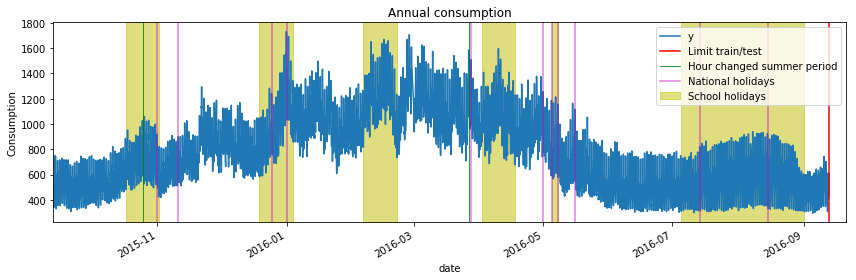

In [4]:
from loading import get_school_holidays
start_date_data = data['date'].values[0]
end_date_data = data['date'].values[-1]

# Dates of school holidays for the zone we are interested in
school_holidays = get_school_holidays(start_date_data, end_date_data)['B']

# Dates of national holidays
national_holidays = data.loc[data['national_holiday'].astype(int).diff() == 1, 'date']

start_date_test = data.loc[data['type'] == 'test', 'date'].values[0]
start_date_summer = data.loc[~data['heure_ete'], 'date'].values[0]
end_date_summer = data.loc[~data['heure_ete'], 'date'].values[-1]

# Ploting the consumption with some info
fig, ax = plt.subplots(figsize=(12, 4))
data.plot('date', 'y', ax=ax)
ylim = ax.get_ylim()
ax.plot([start_date_test]*2, ylim, 'r', label='Limit train/test')
ax.plot([start_date_summer]*2, ylim, 'g', label='Hour changed summer period', linewidth=0.8)
ax.plot([end_date_summer]*2, ylim, 'g', linewidth=0.8)
for i, date in enumerate(national_holidays):
    label = 'National holidays' if i == 0 else ''
    ax.plot([date]*2, ylim, alpha=0.5, color='m', label=label)
for i, holiday_period in enumerate(school_holidays):
    label = 'School holidays' if i == 0 else ''
    ax.fill_betweenx(ylim, holiday_period[0], holiday_period[1], alpha=0.5, color='y', label=label)
ax.set_xlim(data['date'].values[0], data['date'].values[-1])
ax.set_ylabel('Consumption')
ax.set_title('Annual consumption')
ax.legend(loc=0)
ax.set_ylim(ylim)
fig.tight_layout()
fig.savefig('../illustration.png') # This one is for the README.md
if savefigs:
    fig.savefig('./figures/annual_consumption.pdf')

The figure is pretty basic for electricity consumption. The consumption is more important in winter, with a large variability and many peak consumptions. On the other hand, the consumption is much lower in summer and more stable.

Some peaks can be due to calendar reasons, such as new year. But others are hard to explain and are probably due to weather condition, such as storms or cold waves.

#### Influence of school holidays

School holidays clearly changes the behavior of consumption for families. We show below how the mean of the consumption changes for different time steps.

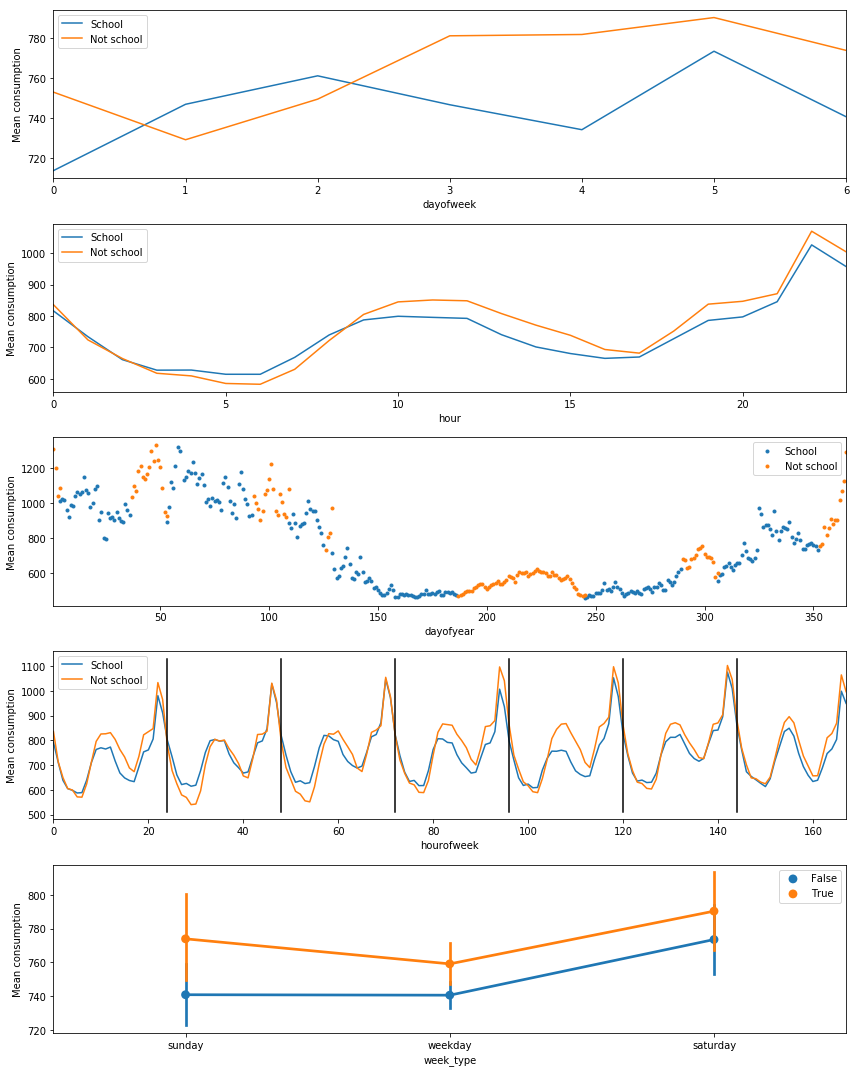

In [5]:
feat_zone = 'holiday_zone_B'
n_time_features = len(time_features)
custom_param_year = {'linestyle': '', 'marker': '.'}
fig, axes = plt.subplots(n_time_features, 1, figsize=(12, 3*n_time_features))
for i, feat in enumerate(time_features):
    param = custom_param_year if feat == 'dayofyear' else {}
    ax = axes[i]
    if feat != 'week_type':        
        data[data[feat_zone] == False].groupby(feat)['y'].mean().plot(ax=ax, label='School', **param)
        data[data[feat_zone] == True].groupby(feat)['y'].mean().plot(ax=ax, label='Not school', **param)
        ax.set_xlim(data[feat].min(), data[feat].max())
    else:
        sns.pointplot(data=data, x=feat, y='y', ax=ax, hue=feat_zone)
    
    ylim = ax.get_ylim()
    if feat == 'hourofweek':
        for j in range(1, 8):
            ax.plot([j*24]*2, ylim, 'k')
    ax.set_ylabel('Mean consumption')
    ax.legend(loc=0)
fig.tight_layout()
if savefigs:
    fig.savefig('./figures/influence_school_holidays.pdf')

Among all these plots, we can clearly observe a difference of consumption behavior. In general, the consumption on during school holidays is higher. This can be shown on the plot with the `week_type` that shows a larger consumption mean for each part of the week. And the following results confirm it:

In [6]:
data.groupby(feat_zone)['y'].mean()

holiday_zone_B
False    744.825668
True     766.670503
Name: y, dtype: float64

The shape of the consumption also greatly changes during a single day, with less consumption in the morning, but much more in the afternoon. The plot with the `hourofweek` highlights this difference.

#### Influence of day type

The type of day in a single week influences the consumption. We split the week in three type of days:

- weekdays,
- saturday,
- sunday.

This is directly linked to humain behabiors which mostly differ on these three types of days. The figure below shows the change of consumption for these three day types.

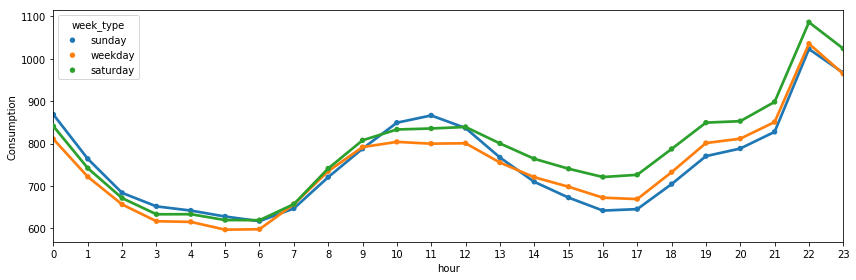

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.pointplot(data=data, x='hour', y='y', hue='week_type', ax=ax, ci=0, markers='.')
ax.set_ylabel('Consumption')
ax.set_xlim(0, 23)
fig.tight_layout()
if savefigs:
    fig.savefig('./figures/influence_week_type.pdf')

#### Influence of national holidays

Since national holidays are not in large number, it is hard to see the true influence of these days. However, we still plot it, but don't make any conclusion on it.

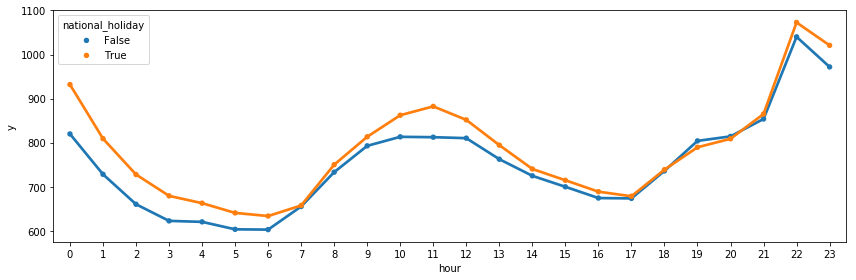

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.pointplot(x='hour', y='y', data=data, ax=ax, hue='national_holiday', ci=0, markers='.')
fig.tight_layout()
if savefigs:
    fig.savefig('./figures/influence_national_holidays.pdf')

### Weather features

We now consider the weather data and plot the evolution of all these variables with the time.

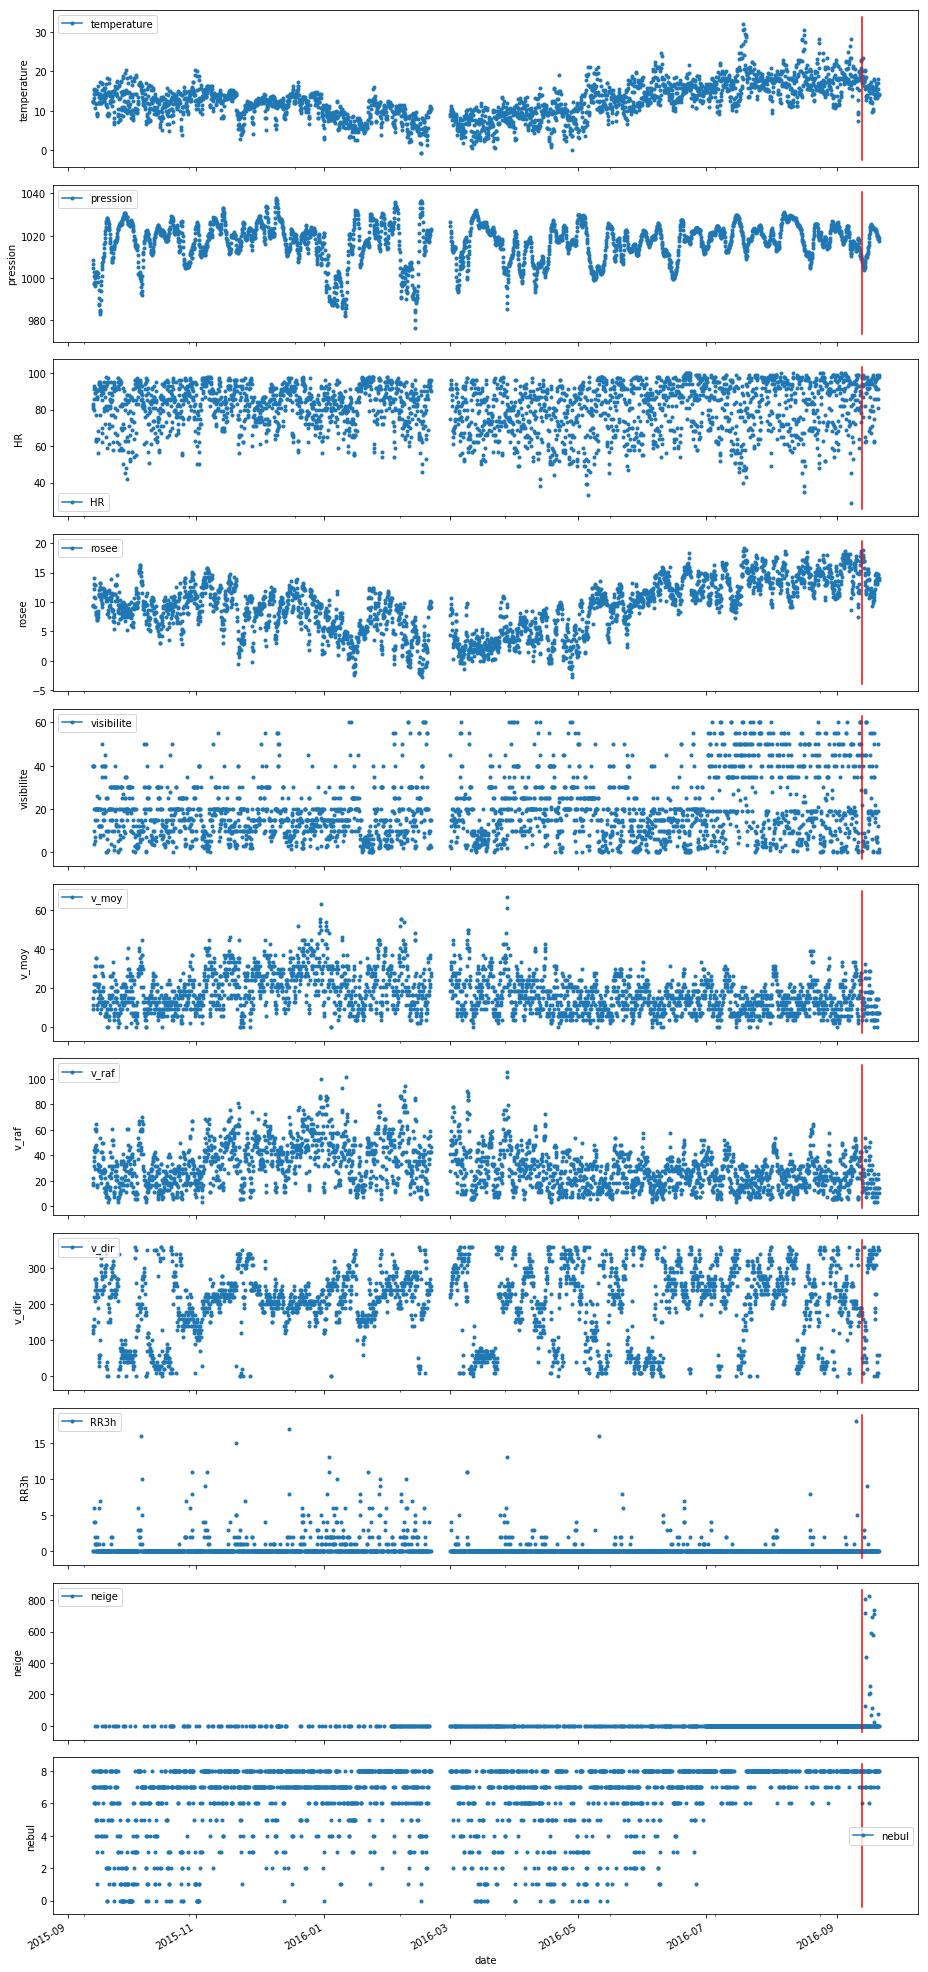

In [9]:
weather_features = ['temperature', 'pression', 'HR', 'rosee', 'visibilite', 
                    'v_moy', 'v_raf', 'v_dir', 'RR3h', 'neige', 'nebul']
# In case some columns disapeared
weather_features = data.columns.intersection(weather_features)

# Test date
start_date_test = data.loc[data['type'] == 'test', 'date'].values[0]

# Ploting the weather feature in a subplot
n_features = len(weather_features)
fig, axes = plt.subplots(n_features, 1, figsize=(13, 2.5*n_features), sharex=True)
for i, feat in enumerate(weather_features):
    ax = axes[i]
    data.plot('date', feat, marker='.', ax=ax)
    ax.plot([start_date_test]*2, ax.get_ylim(), 'r', label='Limit train/test')
    ax.set_ylabel(feat)    
fig.tight_layout()
if savefigs:
    fig.savefig('./figures/weather_data.pdf')

Two important observations can be given from these plots:

- There is a blank window in March 2016 where no weather data have been recorded.
- The snow prediction for the test sample does not have an usual behavior. It predicts snow falls for september... Quiet anormal. However, since no snowfalls were observed in the training set, we assume that the prediction is not correct, so we chose to remove the snow feature from the all dataset.

Lets remove the snow feature.

In [10]:
if 'neige' in data.columns:
    data.drop('neige', axis=1, inplace=True)

#### Cold felt

We consider a new interesting feature that illustrate the felt cold which combines the wind and the temperature. The formula is given by

$$
T_{felt} = (A - T) * \sqrt{V},
$$

where $T$ is the temperature, $V$ the wind, and $A$ is a temperature such as when $T$ is greater than $A$, the wind have no real impact on the consumption. In the following, we decided to fit $A$ such as the correlation between $T_{felt}$ and $y$ is maximum.

In [11]:
from scipy.stats.stats import pearsonr
from scipy.optimize import minimize

def find_param_temp(temp, train):
    """Computes the correlation between the target and the 
    new feature for a given temperature.
    """
    t_wind = (temp-train['temperature']) * np.sqrt(train['v_raf'])
    id_null = t_wind.isnull()
    corr = pearsonr(train.loc[~id_null, 'y'], t_wind[~id_null])[0]
    return -corr

train = data[data['type'] == 'train'].copy()
test = data[data['type'] == 'test'].copy()

# The first row does not have a consumption data. Lets remove it
train = train[train['date'] != '2015-09-13 00:00:00'].reset_index(drop=True)
train = pd.concat([train, test[test['date'] == '2016-09-13 00:00:00']]).reset_index(drop=True)
result = minimize(find_param_temp, 15., args=(train))
temp = result.x
print('Max correlation: %.2f for nominal temperature of %.2f' % (- result.fun, temp))
data['wind_chill'] = (temp-data['temperature']) * np.sqrt(data['v_raf'])

Max correlation: 0.71 for nominal temperature of 19.93


#### Interpolating the weather features

The weather features have lot of missing values to the sampling frequency. We'll do some interpolation to fill the missing values. The interpolation depends of the features :
   
- quadratic interpolation: `temperature`, `pression`, `HR`, `rosee`, `visibilite`, `v_moy`, `v_raf`, `wind_chill`,
- linear interpolation: `v_dir`,
- nearest interpolation: `nebul`, `RR3h`.

In [12]:
from feature_functions import correct_nan_weather
quad_features = ['temperature', 'pression', 'HR', 'rosee', 'visibilite', 'v_moy', 'v_raf', 'wind_chill']
linear_features = ['v_dir']
categorical_features = ['nebul', 'RR3h']
data = correct_nan_weather(data, quad_features=quad_features, linear_features=linear_features, 
                                  categorical_features=categorical_features)
data.head()

,date,y,heure_ete,type,temperature,pression,HR,rosee,visibilite,v_moy,...,RR3h,nebul,national_holiday,dayofweek,hour,dayofyear,hourofweek,week_type,holiday_zone_B,wind_chill
0,2015-09-13 00:00:00,NaN,True,train,12.500000,1008.700000,81.000000,9.300000,40.000000,9.260000,...,0.0,8.0,False,6,0,256,144,sunday,False,31.960776
1,2015-09-13 01:00:00,526.166667,True,train,12.462763,1007.852878,81.968011,9.457683,40.164933,9.656548,...,0.0,8.0,False,6,1,256,145,sunday,False,30.694327
2,2015-09-13 02:00:00,495.000000,True,train,12.396096,1007.086212,82.634677,9.524350,40.164933,10.273881,...,0.0,8.0,False,6,2,256,146,sunday,False,30.419796
3,2015-09-13 03:00:00,446.166667,True,train,12.300000,1006.400000,83.000000,9.500000,40.000000,11.112000,...,0.0,8.0,False,6,3,256,147,sunday,False,31.137184
4,2015-09-13 04:00:00,365.833333,True,train,12.174474,1005.794243,83.063979,9.384633,39.670134,12.170905,...,0.0,8.0,False,6,4,256,148,sunday,False,32.846490


Now lets remove the first row, since it has no consumption value and the interpolation is done.

In [13]:
data = data[data['date'] != '2015-09-13 00:00:00'].reset_index(drop=True)

### Delay features

We assume that there must be a delay in the consumption with some weather data. So we create new delay features in the past hours and weeks (for the target).

We do the same with the consumption but from previous weeks.

In [14]:
shift_features = ['temperature', 'rosee', 'pression', 'wind_chill']
n_hours = [3, 6, 12, 24]
for feat in shift_features:
    for n_hour in n_hours:
        data['%s_shift_%d' % (feat, n_hour)] = data[feat].shift(n_hour)
        
n_weeks = [1, 2, 3, 4]
for n_week in n_weeks:
    data['y_shift_week_%d' % (n_week)] = data['y'].shift(7*24*n_week)

### Target regularization

We create new target features for more regularity, such as the log and the boxcox transformation. We also create difference features on hour, day and week. However, only the hour diff is used in this document for the ARMA process in the next section. A more complex method can be established using these 3 differences, but we did not have the time to implement it.

We also add in the train, the first row of the test sample, since it has the target value on it.

In [15]:
from scipy.stats import boxcox

# Train/test data
train = data[data['type'] == 'train'].copy()
train = pd.concat([train, test[test['date'] == '2016-09-13 00:00:00']]).reset_index(drop=True)
test = data[data['type'] == 'test'].copy().reset_index()
train.drop('type', axis=1, inplace=True)
test.drop('type', axis=1, inplace=True)

train['log_y'] = np.log(train['y'])
train['boxcox_y'], lba_boxcox = boxcox(train['y'])

targets = ['y', 'log_y', 'boxcox_y']
for feat in targets[:]:
    train['diff_%s_h' % (feat)] = train[feat].diff(1) # Hour
    train['diff_%s_d' % (feat)] = train[feat].diff(24) # Day
    train['diff_%s_w' % (feat)] = train[feat].diff(24*7) # Week
    targets.extend(['diff_%s_%s' % (feat, s) for s in ['h', 'd', 'w']])

### Correlation map

The corrlation map of all the data is a bit difficult to visualize, but we can highlight interesting correlations.

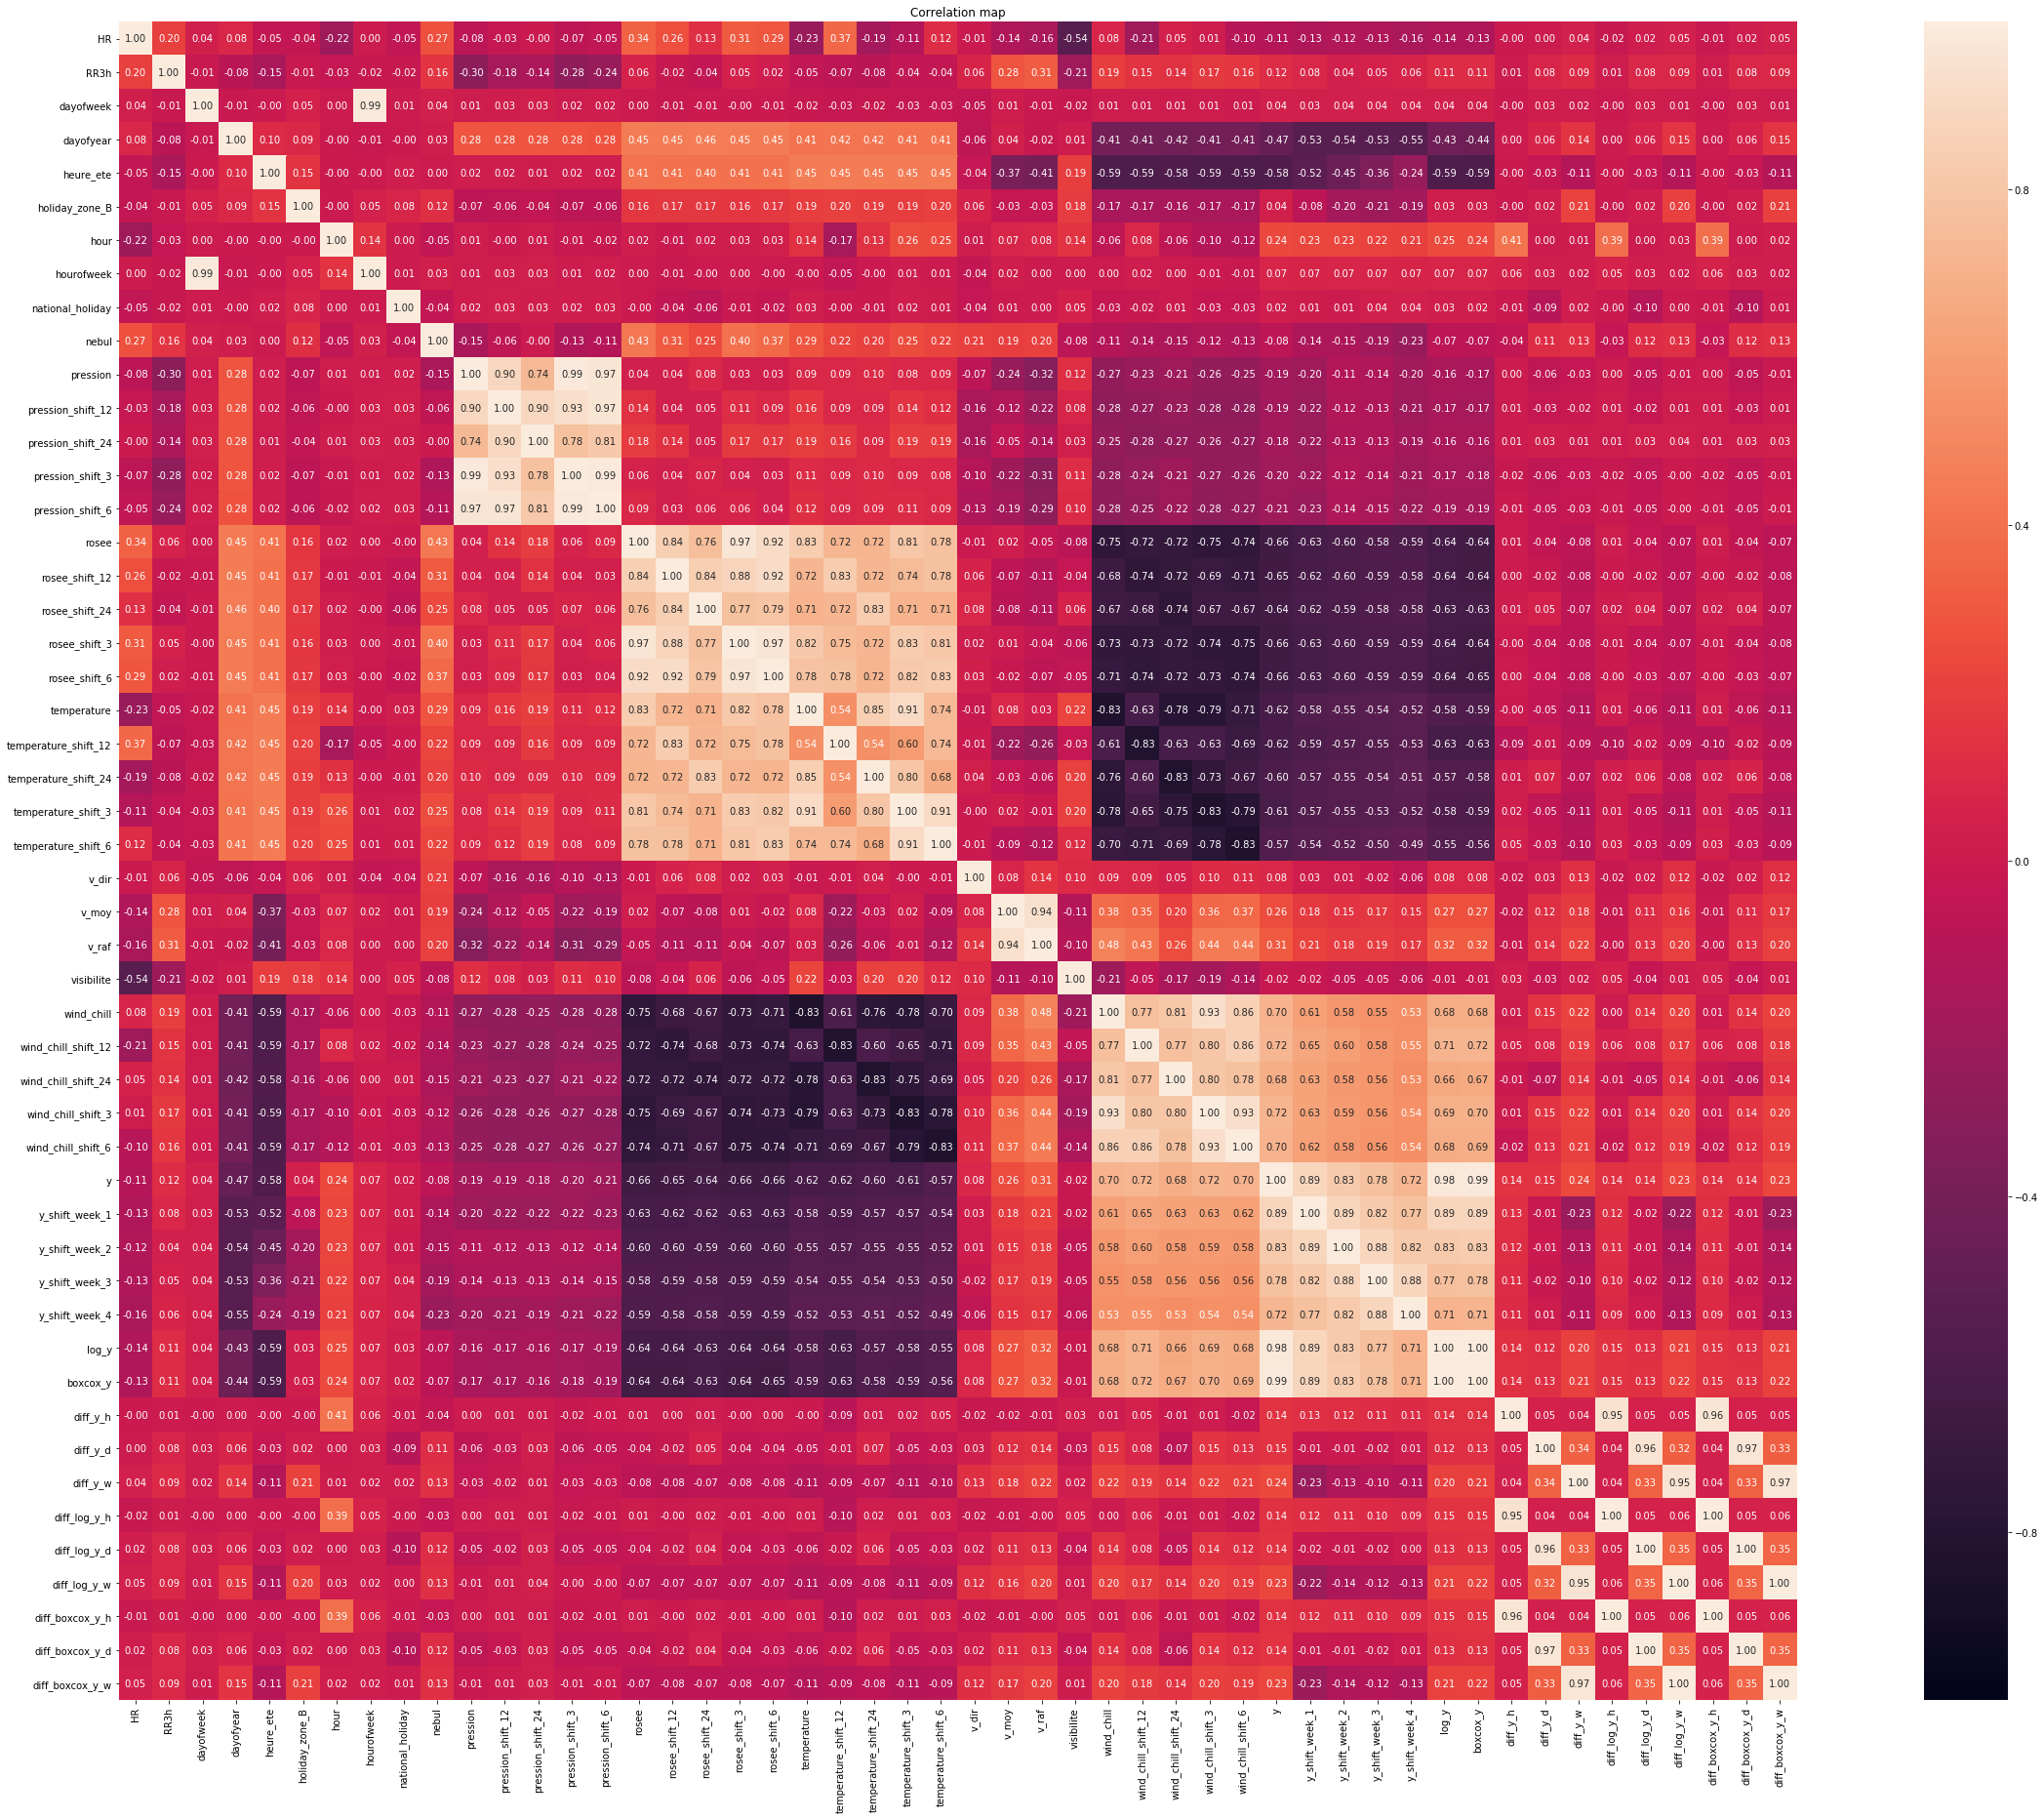

In [16]:
from plots import plot_correlation

plot_correlation(train)

### Local Train/Test sample

Since the prediction is on a 8 days long test, we create a local_test dataframe of 8 days, and the rest is taken for the train data.

In [17]:
from model_functions import create_local_train_test
from feature_functions import correct_history_target

start_local_train = '13-09-2015 00:00'
end_local_train = '05-09-2016 01:00'
n_days_test = 8

local_train, local_test = create_local_train_test(train, start_local_train, end_local_train, n_days_test)

local_test = correct_history_target(local_test, ['y'], n_weeks, n_days_test)

c:\users\naz-probook\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## ARMA model forecasting

In this section, we fit an ARMA model on the `local_train` sample and predict it on the `local_test` sample.

### ACF and PACF plots

diff_y_h


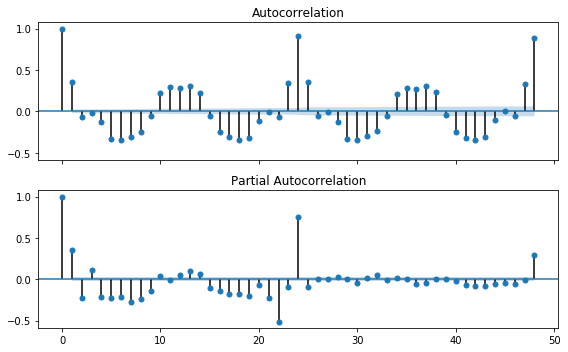

In [18]:
import statsmodels.api as sm
from model_functions import get_df_arma
from model_functions import build_arma_model, pred_arma_train, pred_arma_test, build_arima_model

target = 'y'
use_diff = True
type_diff = 'h'
target_arma = '_'.join(['diff' if use_diff else '', target, type_diff])

print(target_arma)
df_arma = get_df_arma(train, target_arma)
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, sharey=True)
sm.graphics.tsa.plot_acf(df_arma[target_arma].values, lags=48, ax=axes[0])
sm.graphics.tsa.plot_pacf(df_arma, lags=48, ax=axes[1])
fig.tight_layout()
if savefigs:
    fig.savefig('./figures/acf_pacf.pdf')

### Fitting ARMA

With the ACF and PACF plots, we can guess that the parameters should be of 24. In another notebook (also given in the zip file), we tunned $p$, $q$ such that they give the lowest error established on 5 folds: for a given $p$ and $q$, a model is fitted on a training set, we predict on a test set, we compute the erro, then we loop over another train/test split. This confirmes that the model has the lowest error with $p=24$ and $q=24$.

The model is long to fit, so we also gave in the zip file, the already built model that should be automaticly loaded for the optimal hyperparameters.

In [19]:
from functions import mean_absolute_percentage_error, normalized_root_mean_squared_error
maxiter = 100
params_arma = (24, 24)

model_arma = build_arma_model(local_train, target_arma, params=params_arma, maxiter=maxiter)
local_train['y_hat_arma'] = pred_arma_train(model_arma, local_train, target_arma, lba_boxcox=lba_boxcox)
local_test['y_hat_arma'] = pred_arma_test(model_arma, local_train, local_test, target_arma, lba_boxcox=lba_boxcox)
local_train['error_arma'] = local_train['y'] - local_train['y_hat_arma']
local_test['error_arma'] = local_test['y'] - local_test['y_hat_arma']

mape_arma = mean_absolute_percentage_error(local_test['y'], local_test['y_hat_arma'])
print('MAPE: %.2f%%' % (mape_arma))
nrmse_arma = normalized_root_mean_squared_error(local_test['y'], local_test['y_hat_arma'])
print('NRMSE: %.2f%%' % (nrmse_arma))

ADF Statistic: -17.374665
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


c:\users\naz-probook\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


MAPE: 8.21%
NRMSE: 11.44%


The prediction on the test sample is not that bad, except for the 10 and 11 of september. This weekend is very particular, with a unusual consumption and the ARMA underestimated the consumption.

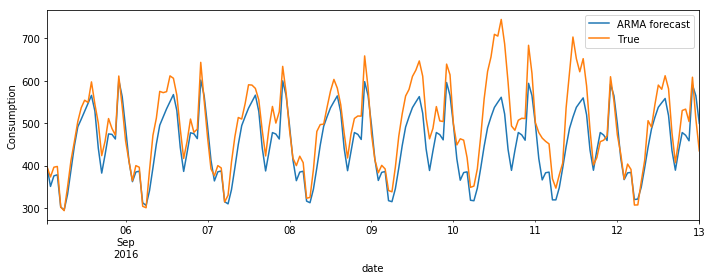

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
local_test.plot('date', 'y_hat_arma', ax=ax, label='ARMA forecast')
local_test.plot('date', 'y', ax=ax, label='True')
ax.set_xlim(local_test['date'].min(), local_test['date'].max())
ax.set_ylabel('Consumption')
fig.tight_layout()
if savefigs:
    fig.savefig('./figures/arma_forecast_local_test.pdf')

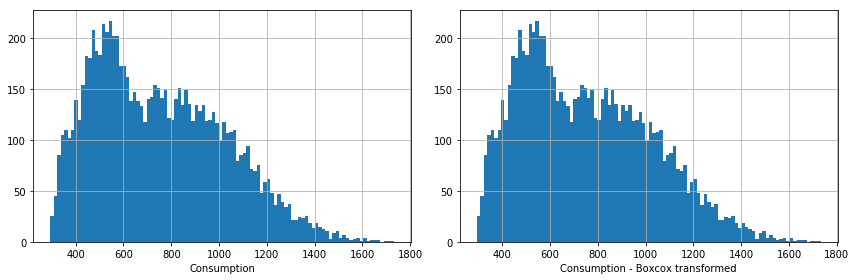

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
train['y'].hist(bins=100, ax=ax)
ax.set_xlabel('Consumption')
ax = axes[1]
train[target].hist(bins=100, ax=ax)
ax.set_xlabel('Consumption - Boxcox transformed')
fig.tight_layout()
if savefigs:
    fig.savefig('./figures/consumption_boxcox.pdf')

## GBM model

### Feature engineering: target encoding

Target encoding is very used in Kaggle competitions to deal with categorical data (see [this paper](https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf)). So we created ratio features on the target based on some input variables.

The ratio feature gives for a given categorical data, it's mean for all the occurences. For example, a ratio of `dayofweek` gives the mean of $y$ for each day of the week. Duo features can be done, which are conditionnal ratio ones. Example: `dayofweek` and `hour` give the mean for each day of the week and for each hour of this day.

A slight regularization is done for the rare occurences. A noise is also added, which seems to be very usefull in the prediction.

In [22]:
from feature_functions import target_encoder

np.random.seed(0)
target_encode = 'boxcox_y'
prior = 'y_shift_week_1'
prior = None
min_samples_leaf = 5
noise_level = 0.1

gb_features = ['dayofweek', 'dayofyear', 'nebul', 'RR3h']
local_train, local_test = target_encoder(local_train, local_test, target_encode,
                                         gb_features=gb_features, prior=prior,
                                         min_samples_leaf=min_samples_leaf, noise_level=noise_level)

gb_features_duo = [['dayofweek', 'hour'], ['holiday_zone_B', 'hour'], ['national_holiday', 'hour'], ['week_type']]
local_train, local_test = target_encoder(local_train, local_test, target_encode,
                                         gb_features=gb_features_duo, prior=prior,
                                         min_samples_leaf=min_samples_leaf, noise_level=noise_level)

drop_features = ['national_holiday', 'holiday_zone_B', 'RR3h', 'nebul', 'heure_ete', 'week_type', 'dayofweek']

### GBT hyperparameter tuning

We fit a Gradient Boosting Model using lightgbm and we tune some hyperparameters with hyperopt over a large number of runs, since the dataset is quiet small.

**Warning: It can be long to run**

In [23]:
from functions import mean_absolute_percentage_error, normalized_root_mean_squared_error, get_error_gbm
from model_functions import build_gbm_model
from hyperopt import fmin, hp, tpe
target = target_encode

target_features = targets + ['y_hat_arma', 'error_arma']
drop_features = target_features + ['date'] + drop_features

features = local_train.columns.difference(drop_features)
X_local_train = local_train[features].values
y_local_train = local_train[target].values
X_local_test = local_test[features].values
y_local_test = local_test[target].values

error = get_error_gbm(mean_absolute_percentage_error, target, lba_boxcox=lba_boxcox)
early_stopping_rounds = 100

n_run = 200
gbm_params = {"objective": 'regression',
              "n_estimators": 10000}

def objective(params):    
    gbm_params['learning_rate'] = params['learning_rate']
    gbm_params['colsample_bytree'] = params['colsample_bytree']
    gbm_params['reg_alpha'] = params['reg_alpha']
    gbm_params['reg_lambda'] = params['reg_lambda']
    gbm_params['min_child_samples'] = int(params['min_child_samples'])
    gbm_params['num_leaves'] = int(params['num_leaves'])
    
    gbm_model = build_gbm_model(X_local_train, y_local_train, X_local_test, y_local_test, gbm_params, early_stopping_rounds=early_stopping_rounds,
                            error=error, verbose=0)
    error_iter = gbm_model.best_score_['valid_0']['error']
    return error_iter

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 0.15),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 0.15),
    'min_child_samples': hp.quniform('min_child_samples', 20, 120, 2),
    'num_leaves': hp.quniform('num_leaves', 20, 120, 2)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=n_run)

print("Best params:", best)

Best params: {'colsample_bytree': 0.6933758121945286, 'learning_rate': 0.04739038078089441, 'min_child_samples': 78.0, 'num_leaves': 80.0, 'reg_alpha': 0.02483704702894882, 'reg_lambda': 0.057140598894884584}


### Fit GBM with the best hyperparameters

Usually, the model should be tuned over multiple folds. However, we did not have the time to do so...

In [24]:
for param in best:
    if param in ['num_leaves', 'min_child_samples']:
        gbm_params[param] = int(best[param])
    else:
        gbm_params[param] = best[param]
    
gbm_model = build_gbm_model(X_local_train, y_local_train, X_local_test, y_local_test, gbm_params, early_stopping_rounds=early_stopping_rounds,
                            error=error, verbose=100)

y_local_pred = gbm_model.predict(X_local_test)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.0792858	valid_0's error: 7.7036
[200]	valid_0's l2: 0.0698101	valid_0's error: 6.94245
[300]	valid_0's l2: 0.0679232	valid_0's error: 6.76396
[400]	valid_0's l2: 0.0676204	valid_0's error: 6.71414
[500]	valid_0's l2: 0.0670994	valid_0's error: 6.6834
[600]	valid_0's l2: 0.0673371	valid_0's error: 6.69648
Early stopping, best iteration is:
[502]	valid_0's l2: 0.0670746	valid_0's error: 6.68112


### GBM importance

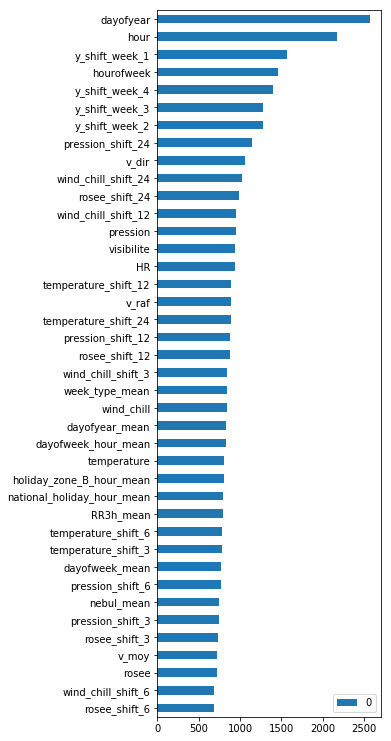

In [25]:
from plots import plot_importance

plot_importance(gbm_model.feature_importances_, features)

### Convert the data

If the boxcox or log has been used as target feature, we convert it to the original one and we plot the result.

MAPE: 6.68%
NRMSE: 9.63%


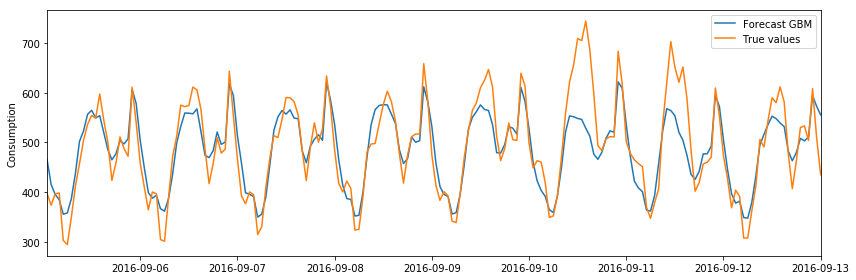

In [26]:
from functions import mean_absolute_percentage_error, normalized_root_mean_squared_error
from scipy.special import inv_boxcox

if target == 'y':
    y_pred = y_local_pred    
elif target == 'log_y':
    y_pred = np.exp(y_local_pred)
elif target == 'boxcox_y':
    y_pred = inv_boxcox(y_local_pred, lba_boxcox)
    
mape = mean_absolute_percentage_error(local_test['y'], y_pred)
print('MAPE: %.2f%%' % (mape))
nrmse = normalized_root_mean_squared_error(local_test['y'], y_pred)
print('NRMSE: %.2f%%' % (nrmse))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(local_test['date'], y_pred, label='Forecast GBM')
ax.plot(local_test['date'], local_test['y'], label='True values')
ax.legend(loc=0)
ax.set_ylabel('Consumption')
ax.set_xlim(local_test['date'].min(), local_test['date'].max())
fig.tight_layout()
if savefigs:
    fig.savefig('./figures/gbm_forecast_local_test.pdf')

## Mixing ARMA and GBM forecast

ARMA has some advantages that GBM does not have. Let's compare the residual errors.

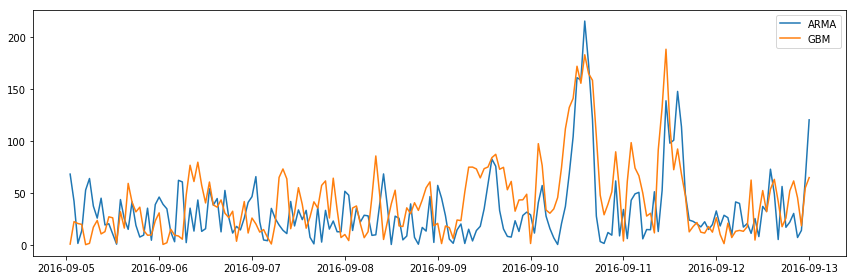

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(local_test['date'], abs(local_test['y'] - y_pred), label='ARMA')
ax.plot(local_test['date'], abs(local_test['error_arma']), label='GBM')
ax.legend(loc=0)
fig.tight_layout()

On the local test, it seems that it looks like the ARMA process is not that bad at the start of the prediction, but becomes less predictive with the time. This is a normal behavior since the ARMA is a time-dependent process, contrary to the GBM model. So a mix between these models could be a good idea. But how can we mix them?

From the assumption that the ARMA is best at the start of of the forecasting, we will give more weight on its prediction and less at the end such as 

$$
\hat y_{pred} = \alpha(t) \hat y_{ARMA} + (1. - \alpha (t)) \hat y_{GBM},
$$

where $\alpha(t)$ is a weight with this form

$$
\alpha (t) = \exp (-\frac{t}{\lambda})
$$

and $\lambda$ is a defines the decreases of the exponential weights.

In the following, we'll determine $\lambda$ such that $\hat y_{pred}$ has the lowest error.

In [28]:
from scipy.optimize import minimize

def mix_pred(param, y_arma, y_gb, linear):
    if linear:
        alpha = param
    else:
        x = np.linspace(0, 1, len(y_arma))
        alpha = np.exp(-x / param)
    y_mix = (alpha * y_arma + (1-alpha)*y_gb)
    return y_mix

def find_optimal_mix(param, y_true, y_arma, y_gb, linear=True):
    y_mix = mix_pred(param, y_arma, y_gb, linear)
    mape = mean_absolute_percentage_error(y_true, y_mix)
    return mape
    
is_linear = False
result = minimize(find_optimal_mix, 0.5, args=(local_test['y'], local_test['y_hat_arma'], y_pred, is_linear))
slope = result.x

y_mix = mix_pred(slope, local_test['y_hat_arma'], y_pred, is_linear)
print('Best param: %.2f' % (slope))
print('MAPE: %.2f%%' % (result.fun))

Best param: 0.31
MAPE: 5.97%


The error is significantly better!

We can plot the resulting weight with the time $\alpha(t)$

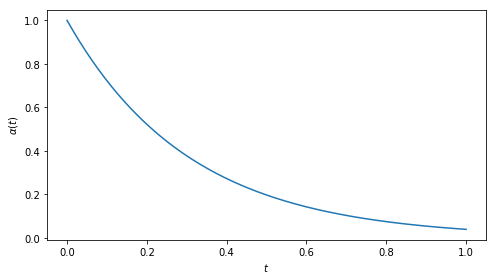

In [29]:
x = np.linspace(0, 1, len(y_pred))
alpha = np.exp(-x / slope)
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, alpha)
ax.set_ylabel('$\\alpha(t)$')
ax.set_xlabel('$t$')
fig.tight_layout()
if savefigs:
    fig.savefig('./figures/param_mix_calibration.pdf')

Below is the prediction on the test sample for the mix. We still observe thise large delay on the weekend of September 11. This weekend is very particular since no information the weather, or this date, that shows this kind of consumption. Probably we could have had a better prediction of this event if we had multiple years of data.

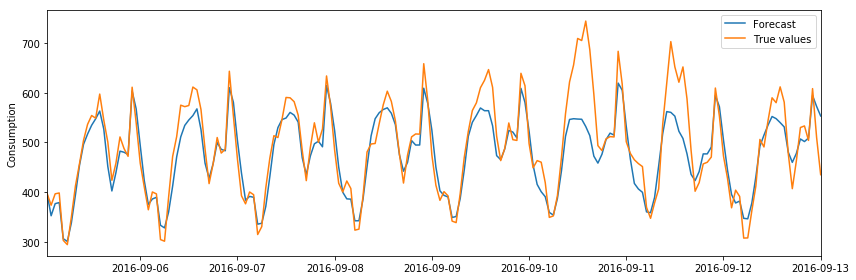

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(local_test['date'], y_mix, label='Forecast')
ax.plot(local_test['date'], local_test['y'], label='True values')
ax.set_ylabel('Consumption')
ax.set_xlim(local_test['date'].min(), local_test['date'].max())
ax.legend(loc=0)
fig.tight_layout()
if savefigs:
    fig.savefig('./figures/mix_forecast_local_test.pdf')

## Prediction on the test sample

Since the score is not too bad, we decided to predict on the test sample. 

### Fitting ARMA model on the whole train sample

Since the ARMA is very dependent of the previous sample, we need to fit one with the whole dataset. To do so, we refit another model with the same $p$ and $q$ as previously and we start the params optimization with the final params of the fited arma_model.

In [31]:
maxiter = 100
params_arma = (24, 24)

full_model_arma = build_arma_model(train, target_arma, params=params_arma, maxiter=maxiter, start_params=model_arma.params)
train['y_hat_arma'] = pred_arma_train(full_model_arma, train, target_arma, lba_boxcox=lba_boxcox)
test['y_hat_arma'] = np.nan
test.loc[0, 'y_hat_arma'] = test.loc[0, 'y']
test.loc[1:, 'y_hat_arma'] = pred_arma_test(full_model_arma, train, test.loc[1:, :], target_arma, lba_boxcox=lba_boxcox)

ADF Statistic: -17.577205
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


c:\users\naz-probook\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


### Target encoding features

As for the building section, we creathe the target sample on the whole training set

In [32]:
np.random.seed(0)

train, test = target_encoder(train, test, target_encode,
                             gb_features=gb_features, prior=prior,
                             min_samples_leaf=min_samples_leaf, noise_level=noise_level)

train, test = target_encoder(train, test, target_encode,
                             gb_features=gb_features_duo, prior=prior,
                             min_samples_leaf=min_samples_leaf, noise_level=noise_level)

### GBM prediction

Using the already built model, we make a prediction on the test data then we mix the result with the $\lambda$ obtained previoulsy.

In [33]:
features = train.columns.difference(drop_features)
X_test = test[features].values

y_pred_test = gbm_model.predict(X_test)

if target == 'y':
    y_pred_test = y_pred_test    
elif target == 'log_y':
    y_pred_test = np.exp(y_pred_test)
elif target == 'boxcox_y':
    y_pred_test = inv_boxcox(y_pred_test, lba_boxcox)
    
y_mix_test = mix_pred(slope, test['y_hat_arma'], y_pred_test, is_linear)

# The last row from the weather sample should not be in the prediction, so we remove it
y_mix_test = y_mix_test[:-1]
y_mix_test.to_csv('../output/LPSM204.csv', index=False)

We observe that the mix prediction is between the other methods. In the first days, the ARMA process is prefered. In the last days, it's the opposite.

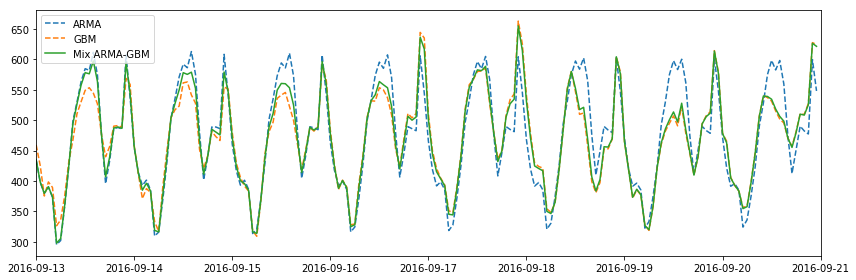

In [34]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test['date'].values[:-1], test['y_hat_arma'].values[:-1], linestyle='--', label='ARMA')
ax.plot(test['date'].values[:-1], y_pred_test[:-1], linestyle='--', label='GBM')
ax.plot(test['date'].values[:-1], y_mix_test, linestyle='-', label='Mix ARMA-GBM')
ax.legend(loc=0)
ax.set_xlim(test['date'].min(), test['date'].max())
fig.tight_layout()
if savefigs:
    fig.savefig('./figures/mix_forecast_test.pdf')

### Test if the result corresponds to the sample_solution convention

And obviously, the samples in the solution are not correct, but we assume that were modified. The trend seems very similar to our submission :). 

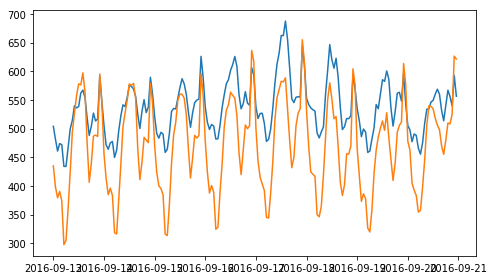

In [35]:
sample_solution = pd.read_csv('../input/sample_solution.csv', header=None)
our_predict = pd.read_csv('../output/LPSM204.csv', header=None)
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(test['date'].values[:-1], sample_solution)
ax.plot(test['date'].values[:-1], our_predict)
fig.tight_layout()